In [1]:
##Data Source https://www.datacamp.com/workspace/datasets/dataset-r-e-commerce
##For PySpark Setup and more information on this project, check https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark


##Import pyspark and create SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/17 09:41:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#Create Spark DataFrame
df = spark.read.csv('/SparkFiles/online_retail.csv',header=True,escape="\"")

In [3]:
#Show first 5 rows
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

In [4]:
#EDA
#Show data count (no of rows)
df.count()

541909

In [5]:
#Count distinct customer IDs
df.select('CustomerID').distinct().count()

4373

In [6]:
#Import Spark functions and types
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [7]:
##Aggregations
##Count of Unique Users, Grouped by Country
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [8]:
##Determine the features for the model
##Recency
##Convert InvoiceDate to standard datetime format
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df2 = df.withColumn('date',to_timestamp("InvoiceDate", 'MM/dd/yy HH:mm'))

In [9]:
df2.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|               date|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
+---------+---------+-----------

In [10]:
##See latest date a purchase was made
df2.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [11]:
##See earliest date a purchase was made
df2.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



In [12]:
##Sort Dataframe by date
df2.orderBy(desc("date")).show(10,0)

+---------+---------+-------------------------------+--------+-------------+---------+----------+-------+-------------------+
|InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate  |UnitPrice|CustomerID|Country|date               |
+---------+---------+-------------------------------+--------+-------------+---------+----------+-------+-------------------+
|581587   |22730    |ALARM CLOCK BAKELIKE IVORY     |4       |12/9/11 12:50|3.75     |12680     |France |2011-12-09 12:50:00|
|581587   |22631    |CIRCUS PARADE LUNCH BOX        |12      |12/9/11 12:50|1.95     |12680     |France |2011-12-09 12:50:00|
|581587   |22556    |PLASTERS IN TIN CIRCUS PARADE  |12      |12/9/11 12:50|1.65     |12680     |France |2011-12-09 12:50:00|
|581587   |22555    |PLASTERS IN TIN STRONGMAN      |12      |12/9/11 12:50|1.65     |12680     |France |2011-12-09 12:50:00|
|581587   |22728    |ALARM CLOCK BAKELIKE PINK      |4       |12/9/11 12:50|3.75     |12680     |France |2011-12-09 12

In [13]:
#Add earliest Invoice date (from above) to each row
df2 = df2.join(df2.select(min("date").alias("from_date")), how='leftouter')

In [14]:
df2.orderBy(desc("date")).show(5,0)

+---------+---------+-------------------------------+--------+-------------+---------+----------+-------+-------------------+-------------------+
|InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate  |UnitPrice|CustomerID|Country|date               |from_date          |
+---------+---------+-------------------------------+--------+-------------+---------+----------+-------+-------------------+-------------------+
|581587   |22555    |PLASTERS IN TIN STRONGMAN      |12      |12/9/11 12:50|1.65     |12680     |France |2011-12-09 12:50:00|2010-12-01 08:26:00|
|581587   |22367    |CHILDRENS APRON SPACEBOY DESIGN|8       |12/9/11 12:50|1.95     |12680     |France |2011-12-09 12:50:00|2010-12-01 08:26:00|
|581587   |22728    |ALARM CLOCK BAKELIKE PINK      |4       |12/9/11 12:50|3.75     |12680     |France |2011-12-09 12:50:00|2010-12-01 08:26:00|
|581587   |22631    |CIRCUS PARADE LUNCH BOX        |12      |12/9/11 12:50|1.95     |12680     |France |2011-12-09 12:50:00

In [15]:
#Compute Recency for each CustomerID:
## 1. Compute recency for each invoice as invoice date - earliest date
## 2. Get max recency for each CustomerID
## 3. Join max recency to the DataFrame on CustomerID

df2 = df2.join(df2.groupBy('CustomerID').agg(max(col("date").cast("long") - col('from_date').cast("long")).alias('recency')),on='CustomerID',how='leftouter')


In [16]:
df2.show(5)

+----------+---------+---------+--------------------+--------+------------+---------+--------------+-------------------+-------------------+-------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|       Country|               date|          from_date|recency|
+----------+---------+---------+--------------------+--------+------------+---------+--------------+-------------------+-------------------+-------+
|     17850|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|6156720|
|     17850|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|6156720|
|     17850|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|6156720|
|     17850|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|United Kingdom|2010-1

In [17]:
#Compute Frequency for each CustomerID following the same steps as above:
df2 = df2.join(df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency')),on='CustomerID',how='leftouter')

In [18]:
df2.show(5)

+----------+---------+---------+--------------------+--------+------------+---------+--------------+-------------------+-------------------+-------+---------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|       Country|               date|          from_date|recency|frequency|
+----------+---------+---------+--------------------+--------+------------+---------+--------------+-------------------+-------------------+-------+---------+
|     17850|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|6156720|      312|
|     17850|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|6156720|      312|
|     17850|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|United Kingdom|2010-12-01 08:26:00|2010-12-01 08:26:00|6156720|      312|
|     17850|   536365|   84029G|KNITTED UNION 

In [19]:
df2.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = true)



In [20]:
#Compute Monetary Value for each CustomerID following the same steps as above:
df2 = df2.join(df2.groupBy('CustomerID').agg(sum(col("Quantity")*col("UnitPrice")).alias('monetary_value')),on='CustomerID',how='inner')

In [21]:
df2.show(5,0)

+----------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+-------+---------+--------------+
|CustomerID|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|Country       |date               |from_date          |recency|frequency|monetary_value|
+----------+---------+---------+----------------------------------+--------+------------+---------+--------------+-------------------+-------------------+-------+---------+--------------+
|16250     |536388   |21754    |HOME BUILDING BLOCK WORD          |3       |12/1/10 9:59|5.95     |United Kingdom|2010-12-01 09:59:00|2010-12-01 08:26:00|9700860|24       |389.44        |
|16250     |536388   |21755    |LOVE BUILDING BLOCK WORD          |3       |12/1/10 9:59|5.95     |United Kingdom|2010-12-01 09:59:00|2010-12-01 08:26:00|9700860|24       |389.44        |
|16250     |536388   |21523    |DOORMAT FANCY FONT HOME SWEE

In [22]:
### Get the distinct results for each user
finaldf = df2.select(['CustomerID','recency','frequency','monetary_value']).distinct()

In [23]:
### Perform data checks
## 1. Sample for user 15574
finaldf.where("CustomerID = 15574").show()

23/11/17 09:42:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+----------+--------+---------+-----------------+
|CustomerID| recency|frequency|   monetary_value|
+----------+--------+---------+-----------------+
|     15574|16947300|      168|702.2500000000002|
+----------+--------+---------+-----------------+



In [24]:
## 2. Sort CustomerID by descending order and check for any duplicates
finaldf.orderBy(desc("CustomerID")).show(10,0)

+----------+--------+---------+----------------------+
|CustomerID|recency |frequency|monetary_value        |
+----------+--------+---------+----------------------+
|18287     |28602180|70       |1837.28               |
|18283     |31980960|756      |2094.8799999999997    |
|18282     |31634220|13       |176.6                 |
|18281     |16684020|7        |80.82                 |
|18280     |8299560 |10       |180.6                 |
|18278     |25932720|9        |173.89999999999998    |
|18277     |27240960|9        |97.63                 |
|18276     |30443700|16       |323.3599999999999     |
|18274     |30765120|22       |1.2434497875801753E-14|
|18273     |32071800|3        |204.0                 |
+----------+--------+---------+----------------------+
only showing top 10 rows



In [25]:
###Alternatively, you can perform multiple aggregations at once using a single agg statement and group by CustomerID
finaldf2 = df2.groupBy("CustomerID").agg(
                              max(col("date").cast("long") - col('from_date').cast("long")).alias('recency'), \
                              count('InvoiceDate').alias('frequency'), \
                            sum(col("Quantity")*col("UnitPrice")).alias('monetary_value'))

In [26]:
finaldf2.orderBy(desc("CustomerID")).show(10,0)

+----------+--------+---------+----------------------+
|CustomerID|recency |frequency|monetary_value        |
+----------+--------+---------+----------------------+
|18287     |28602180|70       |1837.28               |
|18283     |31980960|756      |2094.8799999999997    |
|18282     |31634220|13       |176.6                 |
|18281     |16684020|7        |80.82                 |
|18280     |8299560 |10       |180.6                 |
|18278     |25932720|9        |173.89999999999998    |
|18277     |27240960|9        |97.63                 |
|18276     |30443700|16       |323.3599999999999     |
|18274     |30765120|22       |1.2434497875801753E-14|
|18273     |32071800|3        |204.0                 |
+----------+--------+---------+----------------------+
only showing top 10 rows



In [27]:
##Import all needed modules
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab as pl

23/11/17 09:42:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/17 09:42:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


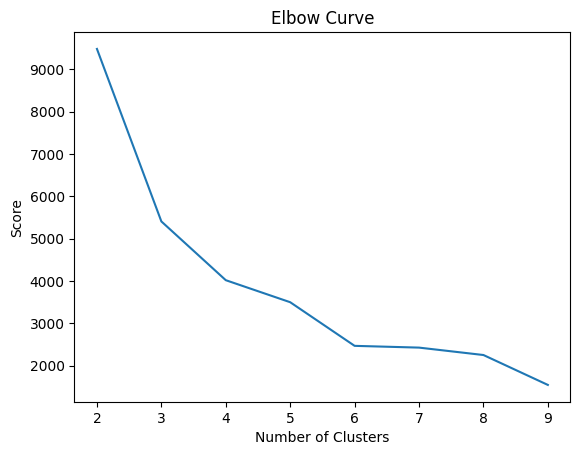

+----------+--------+---------+------------------+------------------------------------+------------------------------------------------------------+----------+
|CustomerID|recency |frequency|monetary_value    |features                            |standardized                                                |prediction|
+----------+--------+---------+------------------+------------------------------------+------------------------------------------------------------+----------+
|16250     |9700860 |24       |389.44            |[9700860.0,24.0,389.44]             |[1.114195397630741,0.10323841364177119,0.047380903626278996]|1         |
|15574     |16947300|168      |702.2500000000002 |[1.69473E7,168.0,702.2500000000002] |[1.9464875961788397,0.7226688954923983,0.08543868008307938] |1         |
|15555     |31218780|925      |4758.200000000001 |[3.121878E7,925.0,4758.200000000001]|[3.58564302501496,3.978980525776598,0.5789025668512755]     |0         |
|15271     |31643100|275      |2485.8199

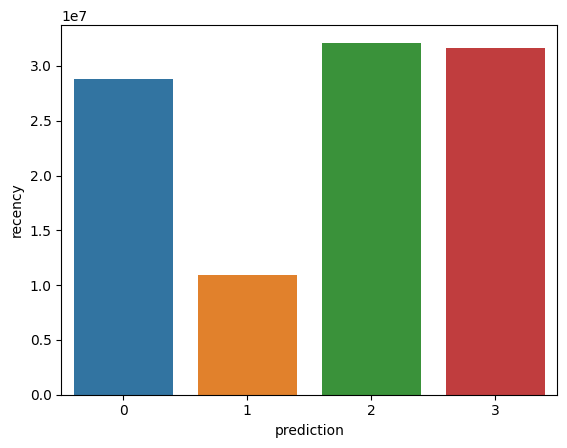

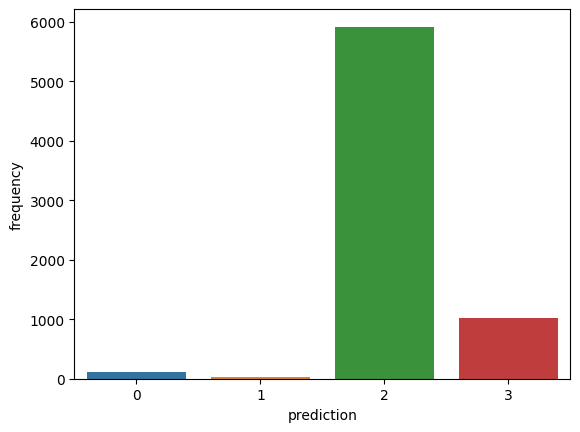

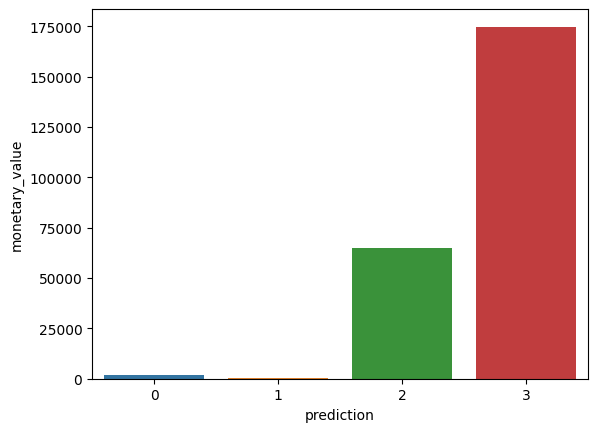

In [28]:
###Now we are going to bucket the users using KNN and based on the three computed features
###First, we have to vectorise the data using VectorAssembler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')
assembled_data=assemble.transform(finaldf2)

##Then we scale the data using StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

####Having scaled the data, we want to determine the optimum value of K (i.e the optimum number of buckets for the users)
###This will be accomplished using the Elbow method
cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost


df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

##Elbow is at 4. Therefore, we can optimally group our Customer data into 4 clusters

##Refit using k=4 clusters
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

## make your predictions
preds=KMeans_fit.transform(data_scale_output)
preds.show(5,0)

###Plot mean of each of the features grouped by the predicted class
df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

In [29]:
evaluator.evaluate(preds)

0.7319344938405782